# 05. Exploring the impact of cyclones on vegetation: fractional cover

This notebook creates returns Fractional Cover (FC) imagery and animations for the scene directly before and directly after a tropical cyclone. 

Cells titled "user requirement" indicate where users are required to edit code, the remaining code should be run normally. 

Code written in Janurary 2018 by Erin Telfer with support from Claire Krause. The notebook was completed as a graduate program project at Geoscience Australia. If you have comment or if you find an error, please contact erin.telfer@ga.gov.au. Alternatively, please contact Claire.Krause@ga.gov.au.

In [1]:
#Import libraries 

%pylab notebook

import pandas as pd
import xarray as xr
from datetime import date, timedelta

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.masking import make_mask

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates
import matplotlib.animation as animation

from IPython.display import display
import ipywidgets as widgets


dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [2]:
###User input: enter the directory location of input data. Ensure "/" are used, not "\"
input_folder = '/g/data/w85/ext547/input_data/'

###User input: enter the directory location of output data. Please enter again if the same as input_folder. Ensure "/" are used, not "\"
output_folder = '/g/data/w85/ext547/cyclone_repo/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [3]:
##User input: enter area of interest

# High Mt QLD Debbie
lat_min = -20.375 #down
lat_max = -20.340 #up
lon_min = 148.757 #left
lon_max = 148.806 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

##User input: enter the name of the area/region/place/location of interest, e.g. "Hamilton Island"
location_name = 'High Mountain'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input: enter the name of cyclone
cyclone_name =  'Debbie'

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.80 

# Datacube query is completed

In [4]:
#Temporal range, wavelengths/band and sensors of interest are defined

#temporal range is defined
start_of_epoch = '2010-01-01'
end_of_epoch =  '2017-12-31'

#wavelengths/bands of interest are defined
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Landsat sensors of interest are defined
sensors = ['ls8', 
    'ls7',
    'ls5'] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2010-01-01', '2017-12-31'), 'x': (148.926, 148.987), 'y': (-20.326, -20.384), 'crs': 'EPSG:4326'}


In [5]:
#Reformat variables

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime
location_name=location_name.replace(" ","_") #replace spaces with underscore

# Data is extracted from Open Datacube

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the ocean/sea will be converted to "nan" values with the 'land_sea' command.

In [6]:
# #Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

basic_pq_mask = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea': 'land'}

In [7]:
#return masked fc information

sensor_clean = {}
for sensor in sensors: 
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'fc')
    print('loading {}'.format(product_name))
    
        # load FC and PQ
    fc = dc.load(product=sensor + '_fc_albers', group_by='solar_day', **query)
    pq = dc.load(product=sensor + '_pq_albers', group_by='solar_day', **query, fuse_func=ga_pq_fuser)
        
    crs = fc.crs
    crswkt = fc.crs.wkt
    affine = fc.affine
        
    # find common observations
    time = (fc.time - pq.time).time  # works!
    fc = fc.sel(time=time)
    pq = pq.sel(time=time)
    
    # mask
    basic_mask = make_mask(pq, **basic_pq_mask).pixelquality
    fc = fc.where(basic_mask)    
    cloud_free = make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud').pixelquality
   
    #filter with cloud free threshold to remove cloudy scenes
    mostly_cloud_free = cloud_free.mean(dim=('x', 'y')) >= cloud_free_threshold
    
    # only those observations that were mostly cloud free
    result = fc.where(mostly_cloud_free).dropna(dim='time', how='all')
    
    
    result.attrs['crs'] = crs
    result.attrs['affine'] = affine
    result.coords['product'] = ('time', numpy.repeat(sensor, result.time.size))
    sensor_clean[sensor] = result

print ('complete')


loading ls8_fc_albers
loading ls7_fc_albers
loading ls5_fc_albers
complete


In [8]:
#Data from different sensors are joined together and sorted so that observations are sorted by time rather than sensor
fc_clean = xr.concat(sensor_clean.values(), 'time')
fc_clean = fc_clean.sortby('time')
fc_clean.attrs['crs'] = crs
fc_clean.attrs['affin|e'] = affine

In [9]:
#Check that the concatenation worked

fc_clean

<xarray.Dataset>
Dimensions:  (time: 125, x: 286, y: 290)
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.752e+06 1.752e+06 1.752e+06 1.752e+06 1.752e+06 ...
  * time     (time) datetime64[ns] 2010-02-02T23:56:36.500000 ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls5' 'ls5' 'ls7' 'ls5' ...
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    UE       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1752350.00|\n| 0.00,-25.00,-2296675.00|\n| 0.00,...
    affin|e:  | 25.00, 0.00, 1752350.00|\n| 0.00,-25.00,-2296675.00|\n| 0.00,...

In [10]:
#create date variables for title
before_date=str(fc_clean.sel(time =start_of_event, method = 'pad').time.values)[0:10]
after_date=str(fc_clean.sel(time =start_of_event, method = 'backfill').time.values)[0:10]

<IPython.core.display.Javascript object>


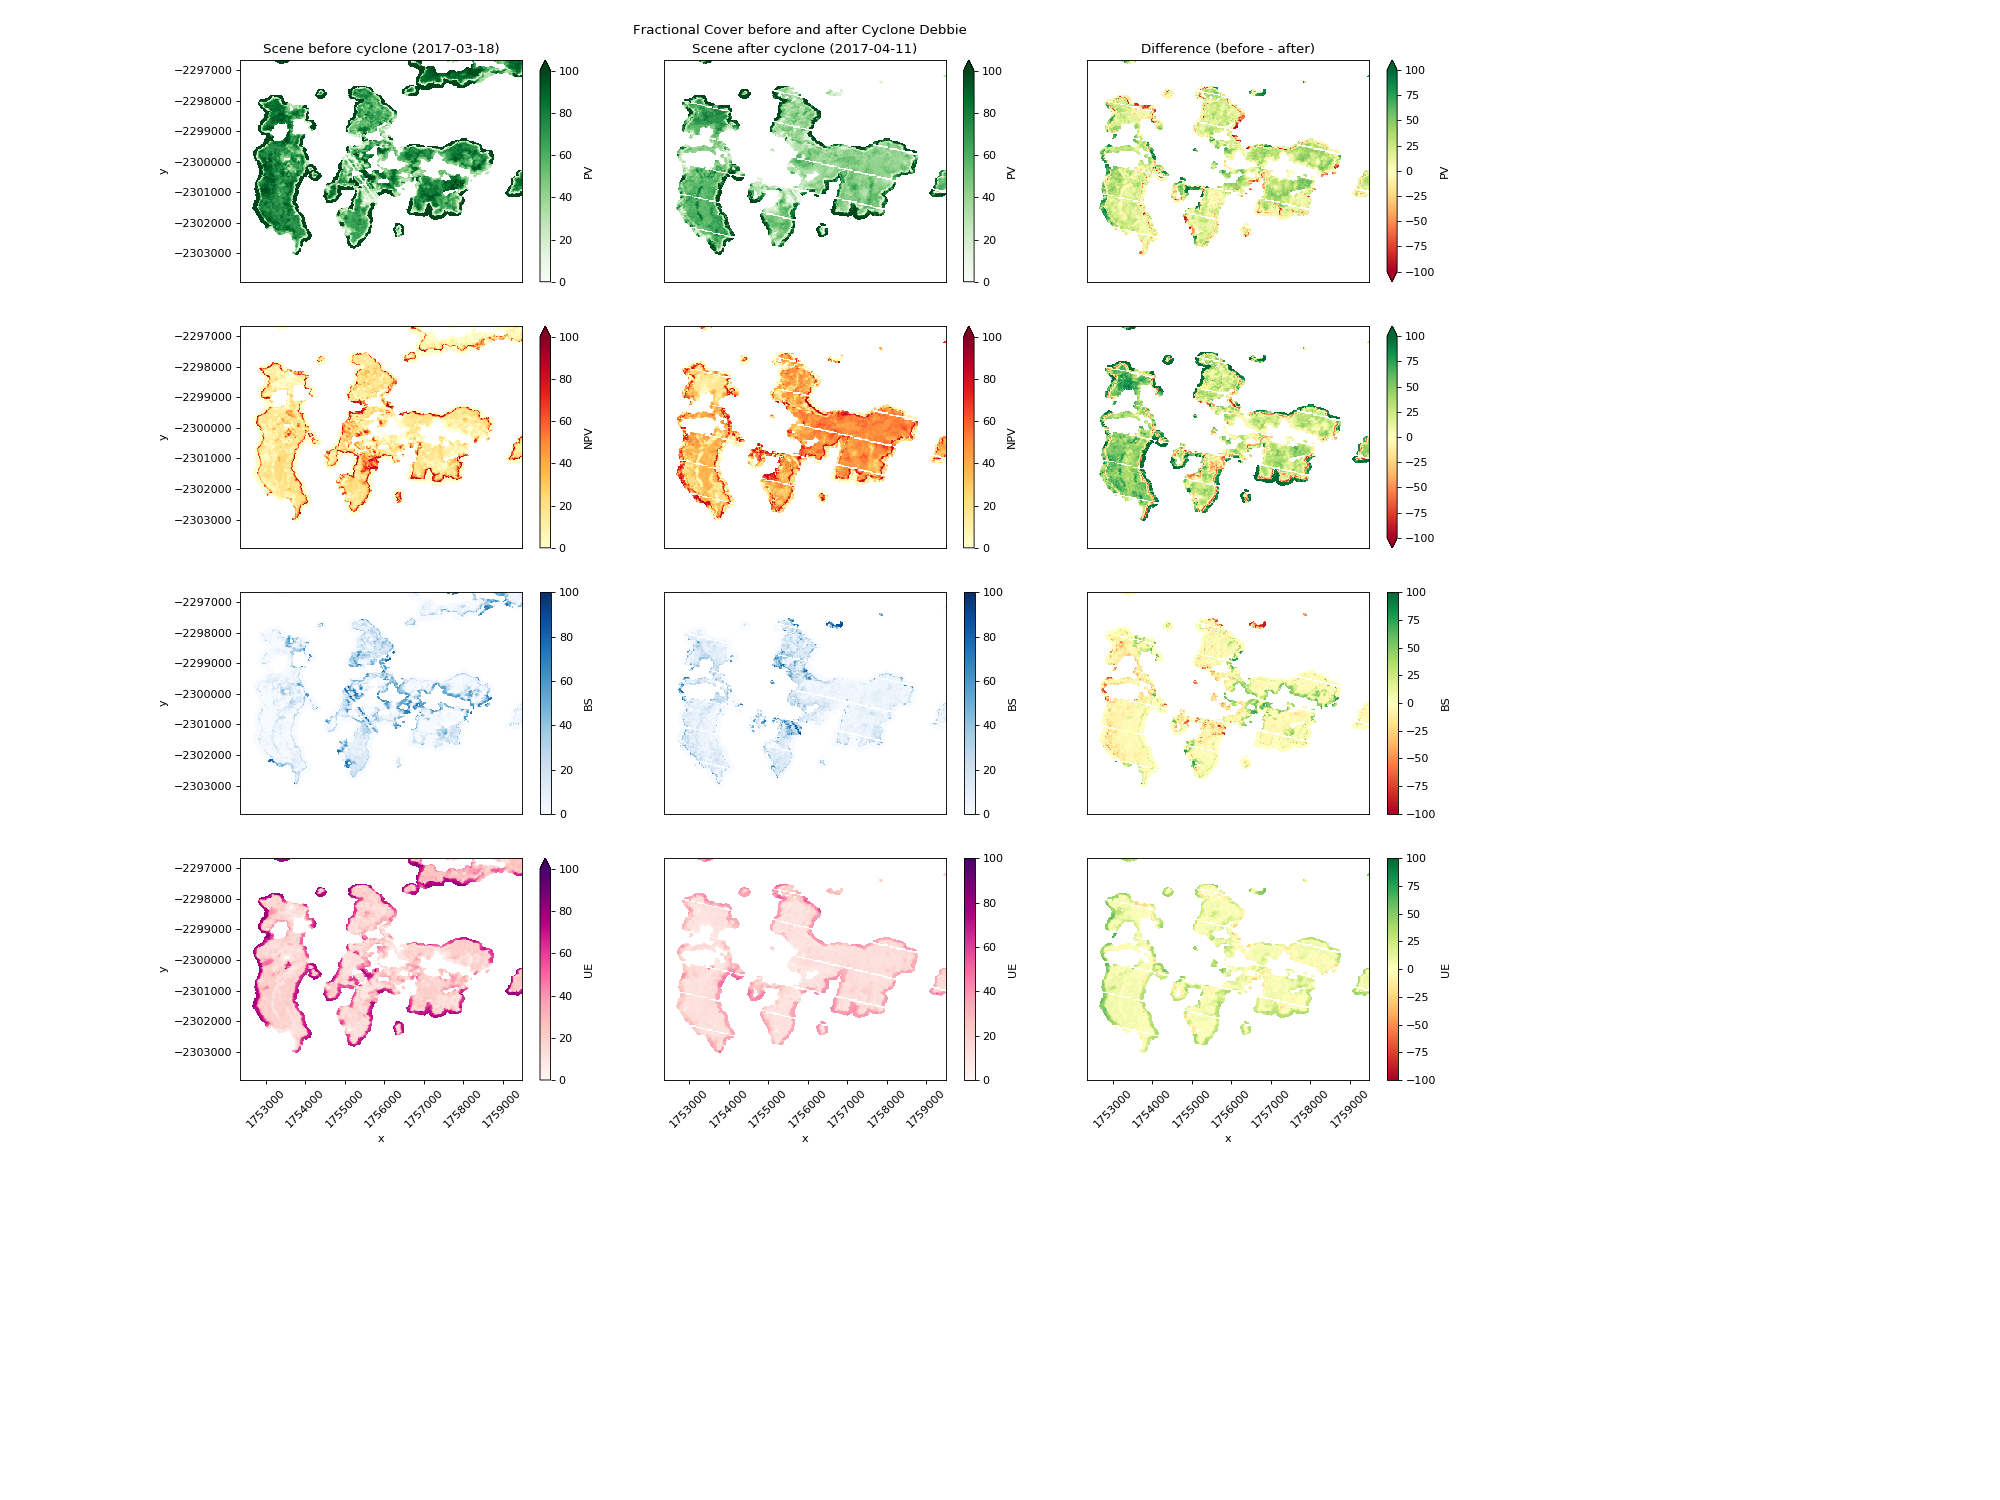

In [13]:
# Create image made up of 12 tiles containg FC components before and after cyclone event. The difference between scenes is also calculated
fig=plt.figure(figsize=(20,15))
plt.subplots_adjust(left=0.15, right=0.90, top=0.95, bottom=0.10) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white
gs = gridspec.GridSpec(4,3)

#PV
ax1=plt.subplot(gs[0,0])
fc_clean.PV.sel(time =start_of_event, method = 'pad').plot(cmap='Greens',vmax=100,vmin=0)
ax1.xaxis.set_visible(False)
ax1.set_title('Scene before cyclone ('+before_date+')')

ax2=plt.subplot(gs[0,1])
fc_clean.PV.sel(time =start_of_event, method = 'backfill').plot(cmap='Greens',vmax=100,vmin=0)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Scene after cyclone ('+after_date+')')

ax3=plt.subplot(gs[0,2])
PV_difference=(fc_clean.PV.sel(time =start_of_event, method = 'pad'))-(fc_clean.PV.sel(time =start_of_event, method = 'backfill'))
PV_difference.plot(cmap='RdYlGn',vmax=100,vmin=-100)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_title('Difference (before - after)')

#NPV
ax4=plt.subplot(gs[1,0])
fc_clean.NPV.sel(time =start_of_event, method = 'pad').plot(cmap='YlOrRd',vmax=100,vmin=0)
ax4.xaxis.set_visible(False)
ax4.title.set_visible(False)

ax5=plt.subplot(gs[1,1])
fc_clean.NPV.sel(time =start_of_event, method = 'backfill').plot(cmap='YlOrRd',vmax=100,vmin=0)
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)
ax5.title.set_visible(False)

ax10=plt.subplot(gs[1,2])
NPV_difference=(fc_clean.PV.sel(time =start_of_event, method = 'pad'))-(fc_clean.NPV.sel(time =start_of_event, method = 'backfill'))
NPV_difference.plot(cmap='RdYlGn',vmax=100,vmin=-100)
ax10.xaxis.set_visible(False)
ax10.yaxis.set_visible(False)
ax10.title.set_visible(False)

#BS
ax6=plt.subplot(gs[2,0])
fc_clean.BS.sel(time =start_of_event, method = 'pad').plot(cmap='Blues',vmax=100,vmin=0)
ax6.xaxis.set_visible(False)
ax6.title.set_visible(False)

ax7=plt.subplot(gs[2,1])
fc_clean.BS.sel(time =start_of_event, method = 'backfill').plot(cmap='Blues',vmax=100,vmin=0)
ax7.xaxis.set_visible(False)
ax7.yaxis.set_visible(False)
ax7.title.set_visible(False)

ax11=plt.subplot(gs[2,2])
BS_difference=(fc_clean.BS.sel(time =start_of_event, method = 'pad'))-(fc_clean.BS.sel(time =start_of_event, method = 'backfill'))
BS_difference.plot(cmap='RdYlGn',vmax=100,vmin=-100)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)
ax11.title.set_visible(False)

#UE
ax8=plt.subplot(gs[3,0])
fc_clean.UE.sel(time =start_of_event, method = 'pad').plot(cmap='RdPu', vmax=100,vmin=0)
ax8.title.set_visible(False)
ax8.tick_params(axis='x', which='major', labelsize=10, labelrotation=45) 

ax9=plt.subplot(gs[3,1])
fc_clean.UE.sel(time =start_of_event, method = 'backfill').plot(cmap='RdPu',vmax=100,vmin=0)
ax9.yaxis.set_visible(False)
ax9.title.set_visible(False)
ax9.tick_params(axis='x', which='major', labelsize=10, labelrotation=45) 

ax12=plt.subplot(gs[3,2])
UE_difference=(fc_clean.UE.sel(time =start_of_event, method = 'pad'))-(fc_clean.UE.sel(time =start_of_event, method = 'backfill'))
UE_difference.plot(cmap='RdYlGn',vmax=100,vmin=-100)
ax12.tick_params(axis='x', which='major', labelsize=10, labelrotation=45) 
ax12.yaxis.set_visible(False)
ax12.title.set_visible(False)

plt.suptitle('Fractional Cover before and after Cyclone '+str(cyclone_name))
plt.show()

In [14]:
#Save figure
plt.savefig(str(output_folder)+'NB05_1_FC_'+str(cyclone_name)+'_'+str(location_name))

# Create RGB image of FC

In [15]:
#prepare imagery
#before event
rgb01 = fc_clean.sel(time =start_of_event, method = 'pad').to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
rgb01 = rgb01.astype('double')
max_val01 = rgb01.max(['y', 'x'])
scaled01 = (rgb01 / max_val01)

#after event
rgb02 = fc_clean.sel(time =start_of_event, method = 'bfill').to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
rgb02 = rgb02.astype('double')
max_val02 = rgb02.max(['y', 'x'])
scaled02 = (rgb02 / max_val02)

<IPython.core.display.Javascript object>


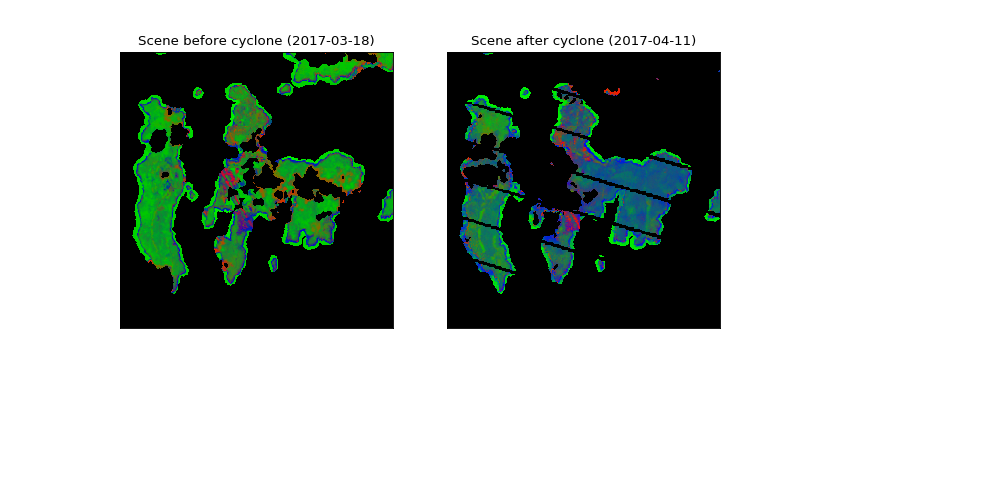

Text(0.5,1,'Scene after cyclone (2017-04-11)')

In [16]:
# plt.clf()
fig=plt.figure(figsize=(10,5))
plt.subplots_adjust(left=0.15, right=0.90, top=0.95, bottom=0.10) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white
gs = gridspec.GridSpec(1,2)

#PV
ax1=plt.subplot(gs[0,0])
ax1.imshow(scaled01, interpolation = 'nearest') #create image
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_title('Scene before cyclone ('+before_date+')')

ax2=plt.subplot(gs[0,1])
ax2.imshow(scaled02, interpolation = 'nearest')
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Scene after cyclone ('+after_date+')')

In [17]:
#Save figure
plt.savefig(str(output_folder)+'NB05_2_FC_before_and_after'+str(cyclone_name)+'_'+str(location_name))

# Create animation that shows FC image before cyclone and then recovery of vegetation over time

In [22]:
#Set animation variables
animation_start=str(fc_clean.sel(time=start_of_event, method = 'backfill').time.values)
animation_end=str(end_of_event+datetime.timedelta(days=400))

FC_first_scene= str(fc_clean.sel(time=start_of_event, method = 'pad').time.values)
PV_first_scene=str(fc_clean.PV.sel(time=start_of_event, method = 'pad').time.values)
NPV_first_scene=str(fc_clean.NPV.sel(time=start_of_event, method = 'pad').time.values)
BS_first_scene=str(fc_clean.BS.sel(time=start_of_event, method = 'pad').time.values)
UE_first_scene=str(fc_clean.UE.sel(time=start_of_event, method = 'pad').time.values)


FC_animation=fc_clean.sel(time=slice(animation_start,animation_end))
FC_first_scene02=fc_clean.sel(time=slice(FC_first_scene,FC_first_scene))


PV_animation=fc_clean.PV.sel(time=slice(animation_start,animation_end))
PV_first_scene02=fc_clean.PV.sel(time=slice(PV_first_scene,PV_first_scene))

NPV_animation=fc_clean.NPV.sel(time=slice(animation_start,animation_end))
NPV_first_scene02=fc_clean.NPV.sel(time=slice(NPV_first_scene,NPV_first_scene))

BS_animation=fc_clean.BS.sel(time=slice(animation_start,animation_end))
BS_first_scene02=fc_clean.BS.sel(time=slice(BS_first_scene,BS_first_scene))

UE_animation=fc_clean.UE.sel(time=slice(animation_start,animation_end))
UE_first_scene02=fc_clean.UE.sel(time=slice(UE_first_scene,UE_first_scene))

KeyError: 

In [21]:
#Create animation for FC rgb
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_FC=[]
data_to_plot_FC =[]
first_scene_FC=[]

for t  in range(0,np.shape(FC_animation.time)[0]):
    time_slice = t
    times_to_plot_FC.append(t)
    rgb = FC_animation.isel(time =time_slice).to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
    rgb = rgb.astype('double')
    max_val = rgb.max(['y', 'x'])
    scaled = (rgb / max_val)
    data_to_plot_FC.append(scaled)

        
for t  in range(0,np.shape(FC_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_FC.append(t)
    rgb = FC_first_scene02.isel(time =time_slice).to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
    rgb = rgb.astype('double')
    max_val = rgb.max(['y', 'x'])
    scaled = (rgb / max_val)
    first_scene_FC.append(scaled)
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)  #figure size  
time_text = plt.title(('FC Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold') #title
im = plt.imshow(first_scene_FC[0], interpolation = 'nearest', animated = True,cmap='Greens',vmax=100,vmin=0) #details for "before"scene

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_FC[0])
    time_text.set_text('FC Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_FC[j])
    time_text.set_text('FC After cyclone '+str(cyclone_name)+' ('+ (str(FC_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_FC),
                              interval=2000, blit=True, repeat=False) #create animation


np.seterr(invalid='raise')#turn numpy warnings back on


NameError: name 'FC_animation' is not defined

# Create animations for components of FC

<IPython.core.display.Javascript object>


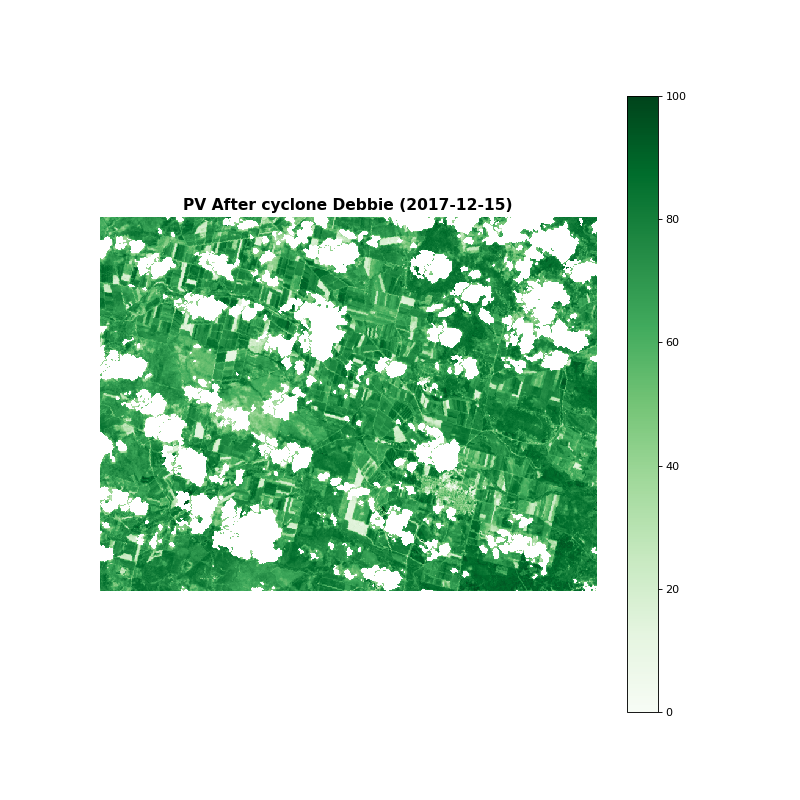

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [21]:
#Create animation for PV
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_PV=[]
data_to_plot_PV =[]
first_scene_PV=[]

for t  in range(0,np.shape(PV_animation.time)[0]):
    time_slice = t
    times_to_plot_PV.append(t)
    data_to_plot_PV.append(PV_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(PV_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_PV.append(t)
    first_scene_PV.append(PV_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('PV before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_PV[0], interpolation = 'nearest', animated = True,cmap='Greens',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_PV[0])
    time_text.set_text('PV before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_PV[j])
#     fig.colorbar(im)
    time_text.set_text('PV after cyclone '+str(cyclone_name)+' ('+ (str(PV_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_PV),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on

<IPython.core.display.Javascript object>


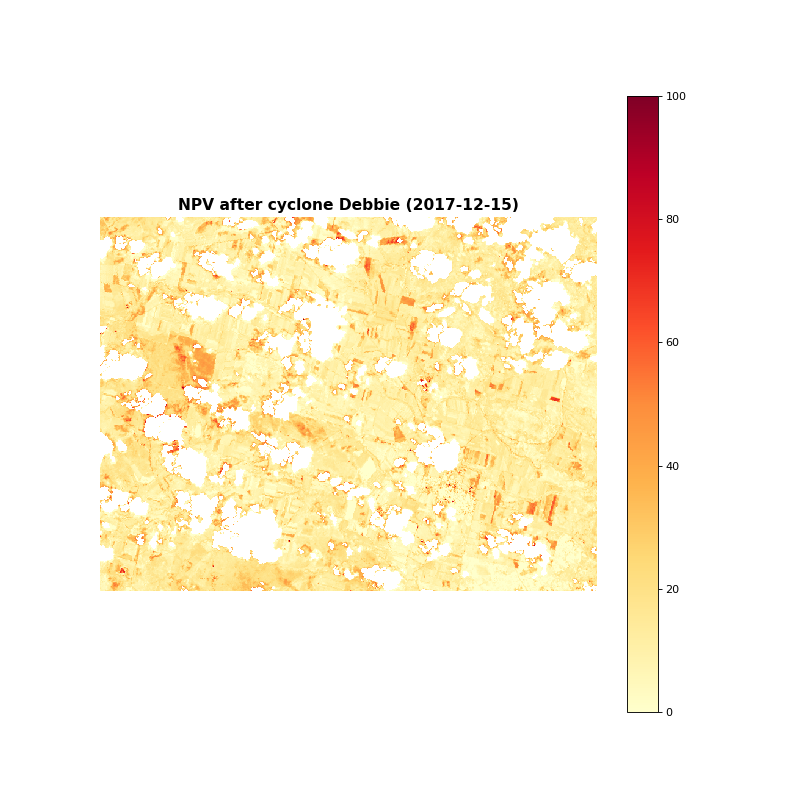

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [22]:
#Create animation for NPV
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_NPV=[]
data_to_plot_NPV =[]
first_scene_NPV=[]

for t  in range(0,np.shape(NPV_animation.time)[0]):
    time_slice = t
    times_to_plot_NPV.append(t)
    data_to_plot_NPV.append(NPV_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(NPV_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_NPV.append(t)
    first_scene_NPV.append(NPV_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('NPV before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_NPV[0], interpolation = 'nearest', animated = True,cmap='YlOrRd',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_NPV[0])
    time_text.set_text('NPV before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_NPV[j])
    fig.colorbar(im)
    time_text.set_text('NPV after cyclone '+str(cyclone_name)+' ('+ (str(NPV_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_NPV),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on


<IPython.core.display.Javascript object>


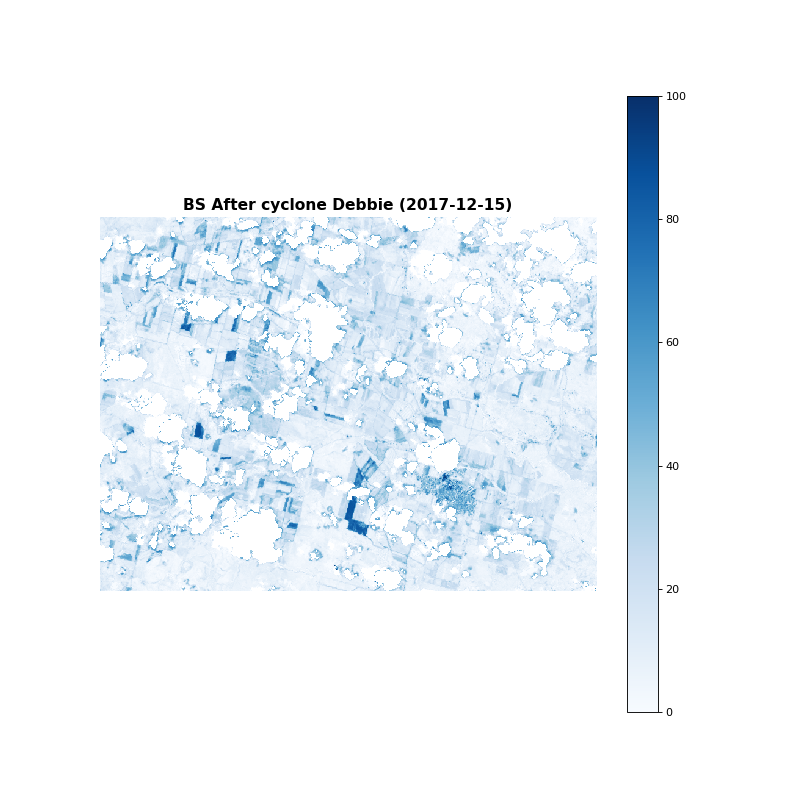

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [23]:
#Create animation for BS
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_BS=[]
data_to_plot_BS =[]
first_scene_BS=[]

for t  in range(0,np.shape(BS_animation.time)[0]):
    time_slice = t
    times_to_plot_BS.append(t)
    data_to_plot_BS.append(BS_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(BS_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_BS.append(t)
    first_scene_BS.append(BS_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('BS Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_BS[0], interpolation = 'nearest', animated = True,cmap='Blues',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_BS[0])
    time_text.set_text('BS Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_BS[j])
    fig.colorbar(im)
    time_text.set_text('BS After cyclone '+str(cyclone_name)+' ('+ (str(BS_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_BS),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on


<IPython.core.display.Javascript object>


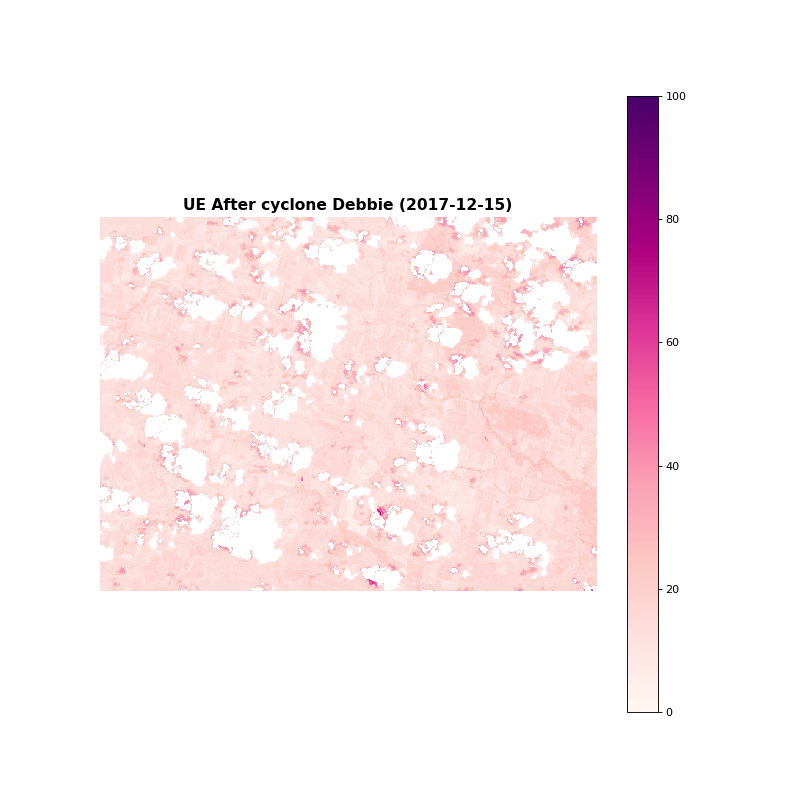

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [25]:
#Create animation for UE
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_UE=[]
data_to_plot_UE =[]
first_scene_UE=[]

for t  in range(0,np.shape(UE_animation.time)[0]):
    time_slice = t
    times_to_plot_UE.append(t)
    data_to_plot_UE.append(UE_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(UE_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_UE.append(t)
    first_scene_UE.append(UE_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('UE Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_UE[0], interpolation = 'nearest', animated = True,cmap='RdPu',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_UE[0])
    time_text.set_text('UE Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_UE[j])
    fig.colorbar(im)
    time_text.set_text('UE After cyclone '+str(cyclone_name)+' ('+ (str(UE_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_UE),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on
